In [1]:
from TopoAnalysis import dem as d
import numpy as np
import pickle as p
import matplotlib.pylab as plt
import seaborn
import random
import pandas as pd

In [2]:
#Loads either 01, 03, or 05 LEMs
conc = '01'
prefix = f'conc_{conc}_Rf05percent_1.0'
directory = '/Users/scdobbs/Desktop/Folders/Active_manuscripts/Geomorph_project/Important_for_manuscript/lems/' #change directory to your own
elev = d.Elevation.load(directory + prefix + '_filled')
fd = d.FlowDirectionD8(flooded_dem = elev)
area = d.Area(flow_direction = fd)
logarea = d.LogArea(area = area)
juncs = p.load(open(directory + 'juncs_' + prefix + '_1E5.p', 'rb'))

In [3]:
"""
Uses TopoAnalysis and junction points of the model filtered to areas >1E5 square meters to find paired flow length paths. 
"""

def paired_flow_lengths(junc, fd):
    
    paired_flow_lengths.to_return = []
    
    def get_divide_flow_lengths(indexes, indexes_o, l = 0):
        
        (i, j) = indexes
        (io, jo) = indexes_o
        
        dl = 1 if (i == io or j == jo) else np.sqrt(2)
        
        l += dl*fd._georef_info.dx
        
        options = fd.get_upstream_cell_indexes(i, j)

        if len(options) == 0:
            paired_flow_lengths.to_return.append(((i, j), l))
        else:
            for (i_next, j_next) in options:              
                get_divide_flow_lengths((i_next, j_next), indexes, l = l)                        
            
    upstream_cells = fd.get_upstream_cell_indexes(junc[0], junc[1])
    upstream_cells = random.sample(upstream_cells, len(upstream_cells))
    subbasins = []
    
    for cell in upstream_cells:
        
        get_divide_flow_lengths(cell, junc)
        subbasins.append(paired_flow_lengths.to_return)
        paired_flow_lengths.to_return = []
                         
    return subbasins


juncs_without_border_cases = [] # Filters out any junctions at borders of model, which would otherwise lead to errors related to having unpaired flow paths at edges of the models.
for junc in juncs:
    if junc[0] < (fd._georef_info.ny - 5) and junc[0] > 5:
        if junc[1] < (fd._georef_info.nx - 5) and junc[1] > 5:
            juncs_without_border_cases.append(junc)

total_lengths_1 = []
total_lengths_2 = []

for junc in juncs_without_border_cases:
    subbasins = paired_flow_lengths(junc, fd)
    subbasin_lengths = []
    for i in range(len(subbasins)):
        subbasin_length = len(subbasins[i])
        subbasin_lengths.append([subbasin_length, i])
    
    sorted_subbasins = sorted(subbasin_lengths)

    subbasin1_indexes, l1 = zip(*subbasins[sorted_subbasins[-1][1]])
    subbasin1_indexes = np.array(subbasin1_indexes)
    l1 = np.array(l1)

    subbasin2_indexes, l2 = zip(*subbasins[sorted_subbasins[-2][1]])
    subbasin2_indexes = np.array(subbasin2_indexes)
    l2 = np.array(l2)
    

    for i in range(subbasin1_indexes.shape[0]):
        dist = np.sqrt(np.power(subbasin1_indexes[i, 0] - subbasin2_indexes[:, 0], 2) + np.power(subbasin1_indexes[i, 1] - subbasin2_indexes[:, 1], 2))

        j = np.where(dist == np.min(dist))
        j = np.random.choice(j[0])
        mindist = dist[j]
        if mindist <= np.sqrt(2) * fd._georef_info.dx:
            total_lengths_1 += [l1[i]]
            total_lengths_2 += [l2[j]]
            
tl_pairs = zip(total_lengths_1, total_lengths_2)
tl_pairs_scrambled = [np.random.choice(p, size=(2,), replace=False).tolist() for p in tl_pairs]
total_lengths_1 = np.array(list(zip(*tl_pairs_scrambled))[0])
total_lengths_2 = np.array(list(zip(*tl_pairs_scrambled))[1])

629
537


(68238,)


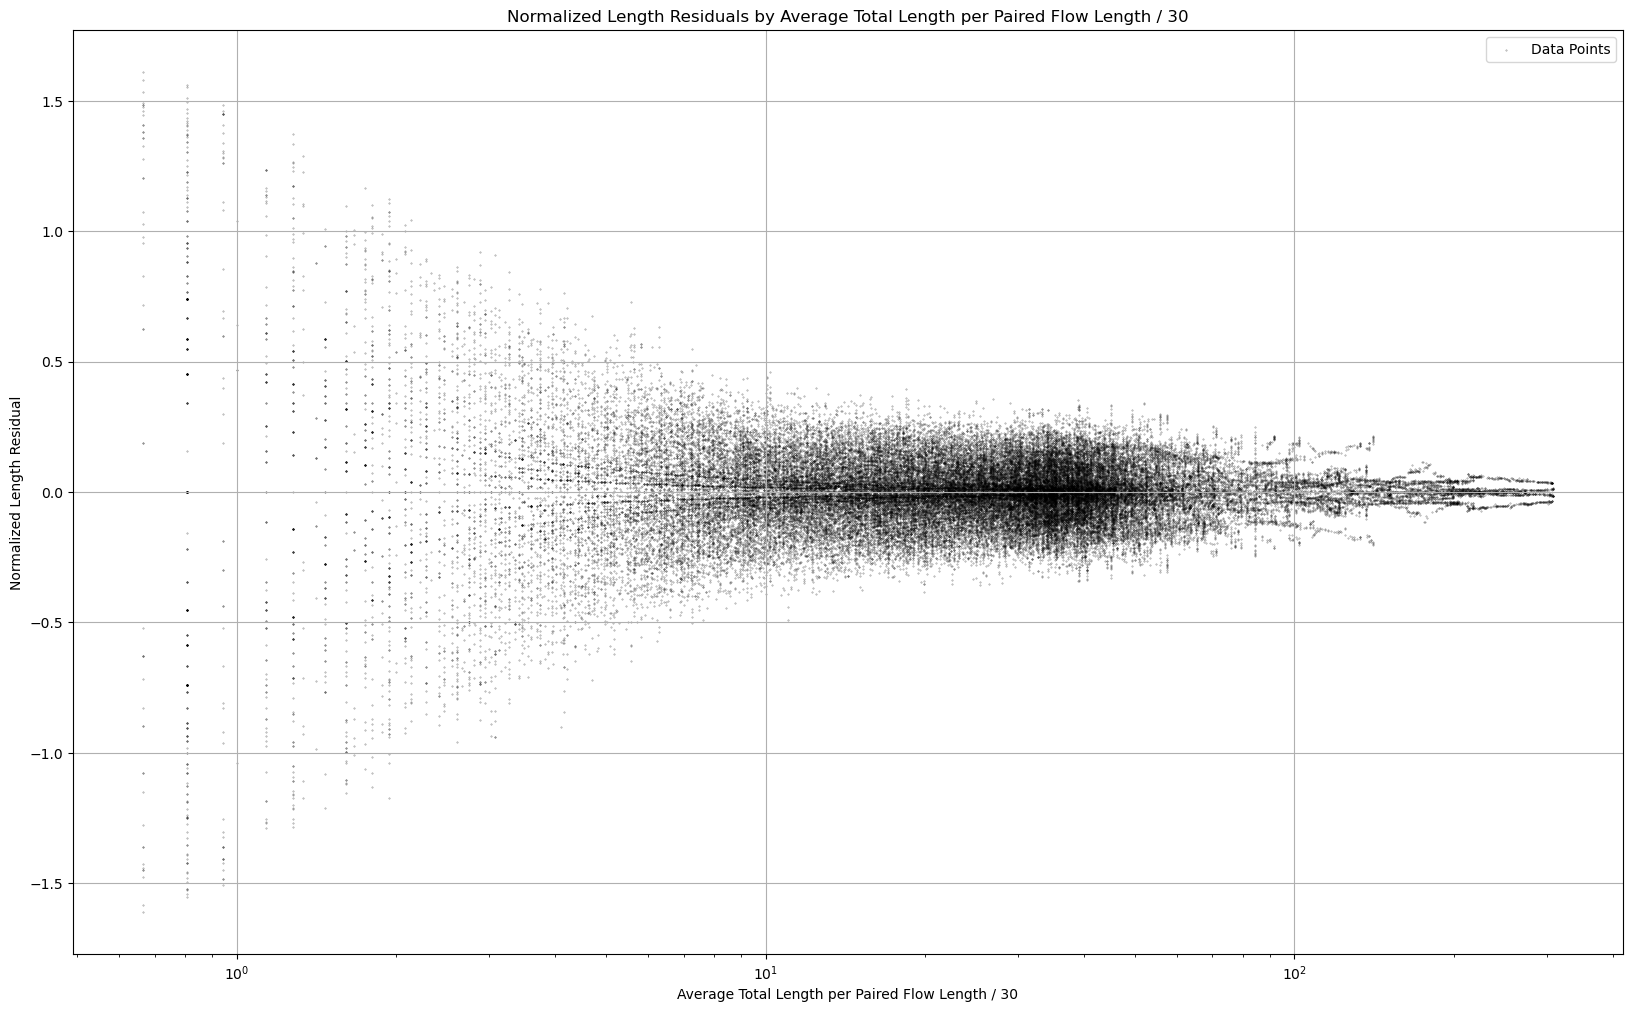

In [4]:
# Assuming the calculation for x_axis_values and normalized_length_resid is done as previously described
total_lengths = np.vstack((total_lengths_1, total_lengths_2))
min_total_lengths = np.min(total_lengths, axis = 0) / 30
print(min_total_lengths.shape)

avg = (total_lengths_1 + total_lengths_2)/2
normalized_length_resid = (total_lengths_1 - total_lengths_2)/avg

# Plotting
plt.figure(figsize=(20, 12))
plt.scatter(min_total_lengths, normalized_length_resid, color='k', s=0.1, alpha=0.5, label='Data Points')

plt.xscale("log")
plt.xlabel('Average Total Length per Paired Flow Length / 30')
plt.ylabel('Normalized Length Residual')
plt.title('Normalized Length Residuals by Average Total Length per Paired Flow Length / 30')
plt.legend()
plt.grid(True)

plt.show()
